<a href="https://colab.research.google.com/github/Roee97/Fake-Voice-Detection/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pydub

In [1]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import ParameterGrid
import torchvision
from IPython.display import Audio
from torchvision.models import ResNet18_Weights


In [5]:
from utils import download_asvspoof2019_data

path = download_asvspoof2019_data()

100%|██████████| 23.6G/23.6G [02:16<00:00, 185MB/s]

Extracting files...


In [6]:
from pydub import AudioSegment
from pydub.playback import play

path = "/root/.cache/kagglehub/datasets/awsaf49/asvpoof-2019-dataset/versions/1"
local_path = "/Users/roeeseren/Documents/semester-seven/deep-learning/project/asvspoof"

remote_path = path
# Load the .flac example file
audio_file = f"{remote_path}/LA/LA/ASVspoof2019_LA_train/flac/LA_T_1004407.flac"
audio = AudioSegment.from_file(audio_file, format="flac")

audio

In [7]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def audio_to_mel_spectrogram(audio_path, n_fft=400, hop_length=160, n_mels=64):
    """
    Convert an audio file to a mel-spectrogram using librosa.
    Args:
        audio_path (str): Path to the audio file.
        n_fft (int): FFT window size.
        hop_length (int): Number of samples between successive frames.
        n_mels (int): Number of mel filterbanks.
    Returns:
        np.ndarray: Mel-spectrogram as a numpy array.
    """
    # Load audio file
    waveform, sample_rate = librosa.load(audio_path, sr=None)

    # Generate mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=waveform,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize to [0, 1]
    log_mel_spectrogram = (log_mel_spectrogram - log_mel_spectrogram.min()) / (log_mel_spectrogram.max() - log_mel_spectrogram.min())

    return log_mel_spectrogram

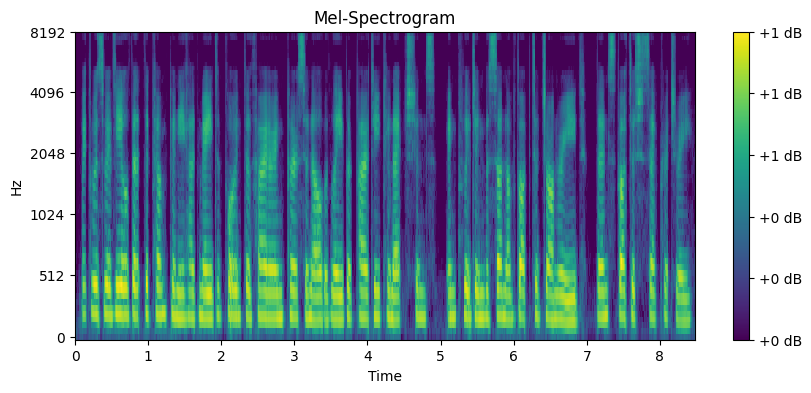

In [8]:
# Example usage
audio_path = audio_file
mel_spectrogram = audio_to_mel_spectrogram(audio_path)

# Visualize the mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=16000, hop_length=160, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.show()

In [54]:
# Load train data
from utils import load_protocol
data_path = "/Users/roeeseren/Documents/semester-seven/deep-learning/project/asvspoof"
data_info_file_path = f"{remote_path}/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"

train_df_info = load_protocol(data_info_file_path, names=['speaker', 'file_name', 'attack', 'label'])

train_df_info.head()

,speaker,file_name,attack,label
0,LA_0079,LA_T_1138215,-,bonafide
1,LA_0079,LA_T_1271820,-,bonafide
2,LA_0079,LA_T_1272637,-,bonafide
3,LA_0079,LA_T_1276960,-,bonafide
4,LA_0079,LA_T_1341447,-,bonafide


In [56]:
eval_info_file_path = f"{path}/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
eval_df_info = load_protocol(eval_info_file_path, names=['speaker', 'file_name', 'attack', 'label'])

eval_df_info.head()

,speaker,file_name,attack,label
0,LA_0039,LA_E_2834763,A11,spoof
1,LA_0014,LA_E_8877452,A14,spoof
2,LA_0040,LA_E_6828287,A16,spoof
3,LA_0022,LA_E_6977360,A09,spoof
4,LA_0031,LA_E_5932896,A13,spoof


In [57]:
def process_data_frame(unprocessed_df):
    mapping = {
      'bonafide': float(0),
      'spoof': float(1)

    }
    df_processed = unprocessed_df[['file_name', 'label']]
    df_processed['label'] = df_processed['label'].map(mapping)

    print(df_processed.head())
    return df_processed

train_df_info = process_data_frame(train_df_info)
eval_df_info = process_data_frame(eval_df_info)

      file_name  label
0  LA_T_1138215    0.0
1  LA_T_1271820    0.0
2  LA_T_1272637    0.0
3  LA_T_1276960    0.0
4  LA_T_1341447    0.0
      file_name  label
0  LA_E_2834763    1.0
1  LA_E_8877452    1.0
2  LA_E_6828287    1.0
3  LA_E_6977360    1.0
4  LA_E_5932896    1.0


<ipython-input-57-2242d0d1e397>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['label'] = df_processed['label'].map(mapping)
<ipython-input-57-2242d0d1e397>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['label'] = df_processed['label'].map(mapping)


In [11]:
from scipy.ndimage import zoom

def resize_spectrogram(spectrogram, fixed_time_steps=192):
    """
    Resize the spectrogram to a fixed time dimension using interpolation.
    Args:
        spectrogram (np.ndarray): Input spectrogram of shape (n_mels, time_steps).
        fixed_time_steps (int): Desired time dimension.
    Returns:
        np.ndarray: Resized spectrogram with shape (n_mels, fixed_time_steps).
    """
    n_mels, time_steps = spectrogram.shape

    # Calculate the zoom factor for the time dimension
    zoom_factor = (1, fixed_time_steps / time_steps)

    # Resize the spectrogram using interpolation
    resized_spectrogram = zoom(spectrogram, zoom_factor)

    return resized_spectrogram

In [80]:
from torch.utils.data import Dataset, DataLoader
import os

class ASVSpoofDataset(Dataset):
    def __init__(self, audio_dir, data_info_df, fixed_time_steps=192):
        """
        Args:
            audio_dir (str): Directory with all the audio files.
        """
        self.audio_dir = audio_dir
        self.audio_files = os.listdir(audio_dir)
        self.data_info_df = data_info_df
        self.fixed_time_steps = fixed_time_steps

    def __len__(self):
        print(f"{len(self.audio_files)}, {len(self.data_info_df)}")
        return min(len(self.audio_files), len(self.data_info_df))

    def __getitem__(self, idx):
        current_audio_path = os.path.join(self.audio_dir, self.audio_files[idx])
        spectrogram = audio_to_mel_spectrogram(current_audio_path)

        # Resize the spectrogram
        mel_spectrogram = resize_spectrogram(spectrogram, self.fixed_time_steps)

        # Convert to tensor and add channel dimension
        mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32).unsqueeze(0)

        # Get label (0 for real, 1 for spoofed)
        label = self.data_info_df.iloc[idx]['label']

        return mel_spectrogram, torch.tensor(label, dtype=torch.float32)

In [81]:
BATCH_SIZE = 32

In [60]:
train_dir = f"{remote_path}/LA/LA/ASVspoof2019_LA_train/flac"
train_dataset = ASVSpoofDataset(train_dir, train_df_info)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

In [82]:
eval_dir = f"{remote_path}/LA/LA/ASVspoof2019_LA_eval/flac"
eval_dataset = ASVSpoofDataset(eval_dir, eval_df_info)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

71933, 71237
71933, 71237


In [84]:
input = 0
label = 0
print(len(eval_dataset))
# eval_df_info.iloc[0]['label']
# for inputs, labels in eval_dataloader:
  # print(f"HELLO {inputs.shape} {labels.shape}")
#   input = inputs
#   label = labels
#   break
# print(input[0].shape)

71933, 71237
71237


In [15]:

import torchvision.models as models
from torchvision.models import ResNet18_Weights

# Load ResNet18 with pretrained weights
resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Modify the first layer to accept 1-channel input
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final layer for binary classification
resnet18.fc = nn.Linear(resnet18.fc.in_features, 1)

# Add a sigmoid activation for binary output
resnet18 = nn.Sequential(resnet18, nn.Sigmoid())

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [38]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# # Training loop
# for epoch in range(10):  # Number of epochs
#     resnet18.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for inputs, labels in train_dataloader:
#         inputs, labels = inputs.to(device), labels.to(device).float()

#         # Forward pass
#         outputs = resnet18(inputs).squeeze()
#         loss = criterion(outputs, labels)

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Calculate accuracy
#         predicted = (outputs > 0.5).float()
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         running_loss += loss.item()

#     # Print epoch statistics
#     epoch_loss = running_loss / len(train_dataloader)
#     epoch_accuracy = 100 * correct / total
#     print(f"Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

import train_utils
import importlib
importlib.reload(train_utils)

<module 'train_utils' from '/content/train_utils.py'>

In [46]:
eval_info_file_path = f"{path}/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
eval_df_info = load_protocol(eval_info_file_path, names=['speaker', 'file_name', 'attack', 'label'])

print(eval_df_info.head())
eval_df_info = process_data_frame(eval_df_info)

   speaker     file_name attack  label
0  LA_0039  LA_E_2834763    A11  spoof
1  LA_0014  LA_E_8877452    A14  spoof
2  LA_0040  LA_E_6828287    A16  spoof
3  LA_0022  LA_E_6977360    A09  spoof
4  LA_0031  LA_E_5932896    A13  spoof
      file_name  label
0  LA_E_2834763    1.0
1  LA_E_8877452    1.0
2  LA_E_6828287    1.0
3  LA_E_6977360    1.0
4  LA_E_5932896    1.0


<ipython-input-10-594fd86ccd0c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['label'] = df_processed['label'].map(mapping)


In [19]:
eval_dir = f"{remote_path}/LA/LA/ASVspoof2019_LA_eval/flac"
eval_dataset = ASVSpoofDataset(eval_dir, eval_df_info)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

(tensor([[[ 2.0586e-01,  3.4187e-01,  2.3326e-01,  ...,  3.6336e-01,
            3.8231e-01,  0.0000e+00],
          [ 2.7246e-01,  4.1217e-01,  3.1236e-01,  ...,  3.8427e-01,
            4.5312e-01,  0.0000e+00],
          [ 3.0064e-01,  3.8411e-01,  3.2450e-01,  ...,  2.7918e-01,
            4.4309e-01,  0.0000e+00],
          ...,
          [ 1.8583e-37,  1.3999e-37, -1.0608e-37,  ...,  2.5278e-01,
            4.5637e-02,  0.0000e+00],
          [ 8.5683e-38, -3.0184e-38, -2.8577e-38,  ...,  2.4808e-01,
            2.6437e-02,  0.0000e+00],
          [ 3.1780e-37, -4.2774e-37, -1.4757e-38,  ...,  1.5842e-01,
           -6.8030e-03,  0.0000e+00]]]),
 tensor(0.))

In [61]:
input = 0
label = 0
# eval_df_info.iloc[0]['label']

for i, (inputs, labels) in enumerate(eval_dataloader):
  print("HELLO")
  input = inputs
  label = labels
  break
print(input[0].shape)

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "<ipython-input-12-e543b35e21ac>", line 29, in __getitem__
    label = self.data_info_df.iloc[idx]['label']
            ~~~~~~~~~~~~~~~~~~~~~~^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexing.py", line 1191, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexing.py", line 1752, in _getitem_axis
    self._validate_integer(key, axis)
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/indexing.py", line 1685, in _validate_integer
    raise IndexError("single positional indexer is out-of-bounds")
IndexError: single positional indexer is out-of-bounds


In [ ]:
train_utils.train_model(model=resnet18, train_loader=train_dataloader, val_loader=eval_dataloader,criterion=criterion, optimizer=optimizer, epochs=5, device=device)
# EPOCHS = 2
# # Initialize lists to save loss and accuracy values for each epoch
# epoch_losses = []
# epoch_accuracies = []

# # Assuming this is inside your training loop
# for epoch in range(EPOCHS):
#     resnet18.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     iteration_number = 0

#     for inputs, labels in train_dataloader:
#         # inputs = inputs.unsqueeze(1)
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = resnet18(inputs)
#         outputs = outputs.squeeze(1)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         # Calculate accuracy - changed outputs.max(1) to outputs.max(0) since only 1 dimension
#         _, predicted = outputs.max(0) # Assuming binary classification, use argmax for prediction
#         predicted = (predicted > 0.5).float() # Apply threshold to get class labels (0 or 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         if iteration_number % 50 == 0:
#           print(f"iteration number: {iteration_number} finished")
#         iteration_number += 1

#     # Calculate and save epoch loss and accuracy
#     epoch_loss = running_loss / len(train_dataloader)
#     epoch_losses.append(epoch_loss)

#     epoch_accuracy = 100 * correct / total
#     epoch_accuracies.append(epoch_accuracy)

#     print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x786ff87749a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    

Progress - enumeration 0 / 794


if w.is_alive():
       ^^^^^^^^^^^^Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x786ff87749a0>  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

     self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x786ff87749a0> 

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
if w.is_alive():     
self._shutdown_workers()  
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
     if w.is_alive():   
       ^ ^   ^ 

Progress - enumeration 50 / 794
Progress - enumeration 100 / 794
Progress - enumeration 150 / 794
Progress - enumeration 200 / 794
Progress - enumeration 250 / 794
Progress - enumeration 300 / 794
Progress - enumeration 350 / 794
Progress - enumeration 400 / 794
Progress - enumeration 450 / 794
Progress - enumeration 500 / 794
Progress - enumeration 550 / 794
Progress - enumeration 600 / 794
Progress - enumeration 650 / 794
Progress - enumeration 700 / 794
Progress - enumeration 750 / 794
71933, 71237
71933, 71237
